Best Fit Curve: y=
            3             2
-9.869e-07 x + 9.806e-05 x - 0.00405 x + 0.1155


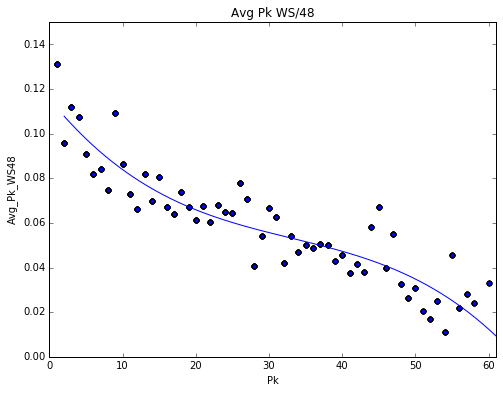

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit
%matplotlib inline

# Read data and limit to 2015 or earlier
df = pd.DataFrame.from_csv('data.csv')
df = df.loc[df['Year'] <= 2015]

# Take average pick value
df['Avg_Pk_WS48'] = df.groupby('Pk')['WS/48'].transform(lambda x: x.mean())

# Curve fitting seems to do the trick, although I'd like to keep pick #1 without the curve fit
X = df['Pk']
Y = df['Avg_Pk_WS48']
z = np.polyfit(X, Y, 3)   
f = np.poly1d(z)
x_new = np.linspace(2, 61, 500)
y_new = f(x_new)
print "Best Fit Curve: y="
print f
df.plot(y='Avg_Pk_WS48', x='Pk', kind='scatter', \
          title='Avg Pk WS/48', xlim=(0, 61), ylim=(0, 0.15), figsize=(8, 6))
plt.plot(x_new, y_new)

In [2]:
df = df.sort_values('Pk')
x = df['Pk']

# Apply curve fit
df['Curve_Fit_Pk_WS48'] = f[3]*(x**3) + f[2]*(x**2) + f[1]*x + f[0]
# Replace #1 suggested by curve fir with simple average #1 pick
df.loc[df.Pk == 1, ['Curve_Fit_Pk_WS48']] = df['Avg_Pk_WS48']

In [3]:
df = df.sort_values('Pk')
df = df.set_index('Year')

# Create lists of variables and following
WS = df['WS/48'].groupby(df.index).agg(lambda x: list(list(x)))
cum_list = []
for i in range(1996, 2016):
    mini_list = []
    for j in range(len(WS[i])):
        mini_list.append(WS[i][j:j+7])
    cum_list.append(mini_list)
cum_list = [item for sublist in cum_list for item in sublist]
 
df = df.reset_index().sort_values(['Year', 'Pk'])

# Sequence for weighing pick value. The selection is worth 1, the next pick is worth 0.75, etc.
simple_transform = [[1, 0.75, 0.55, 0.40, 0.25, 0.15, 0.10, 0.07, 0.05, 0.04, 0.03, 0.02, 0.01] for i in range(len(df))]
print "Weight Sequence:", simple_transform[0]
    
# Apply sequence
df['Weighted_Following_WS48'] = [sum([y*simple_transform[xi][yi]/sum(simple_transform[0]) for yi,y in enumerate(x)])
                                 for xi,x in enumerate(cum_list)]
df.sort('Weighted_Following_WS48', ascending=False).head(10)[['Year', 'Pk', 'Player', 'Weighted_Following_WS48']]

Weight Sequence: [1, 0.75, 0.55, 0.4, 0.25, 0.15, 0.1, 0.07, 0.05, 0.04, 0.03, 0.02, 0.01]


C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Year,Pk,Player,Weighted_Following_WS48
10,2007,1,Greg Oden,0.147412
1,1997,1,Tim Duncan,0.138026
39,2007,2,Kevin Durant,0.137471
14,2003,1,LeBron James,0.136550
257,1996,13,Kobe Bryant,0.130219
77,2008,4,Russell Westbrook,0.130161
12,2009,1,Blake Griffin,0.130015
166,1998,9,Dirk Nowitzki,0.129518
79,2005,4,Chris Paul,0.127442
40,2005,3,Deron Williams,0.126433


In [4]:
# Compare more to what's next at the top, avg at bottom with sliding scale
# 50/50 Avg pick value vs. following pick actual value at #1 pick, 100% avg. pick value at bottom 
# (solves Isaiah Thomas/Kobe Bryant problem)
df['Sliding Scale'] = (df['Pk'].astype(float)+58)/118
df['Sliding Scale2'] = 1 - df['Sliding Scale']
df['Pick Value'] = df['Curve_Fit_Pk_WS48']*df['Sliding Scale'] +\
                        df['Weighted_Following_WS48']*df['Sliding Scale2']
    
# Most valuable picks is now pretty reasonable
df.sort('Pick Value', ascending=False).head(50)[['Year', 'Pk', 'Pick Value']]

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Year,Pk,Pick Value
10,2007,1,0.139331
1,1997,1,0.134638
14,2003,1,0.133900
12,2009,1,0.130632
6,2005,1,0.125450
17,1996,1,0.123308
0,2004,1,0.123235
18,2011,1,0.123147
11,2012,1,0.122613
39,2007,2,0.122387


In [5]:
# Metric is just the WS/48 minus the pick value
df['Difference'] = df['WS/48'] - df['Pick Value']
# Top 50 according to metric
df.sort('Difference', ascending=False)[['Year', 'Pk', 'Player', 'Tm', 'Difference']].head(50)

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Year,Pk,Player,Tm,Difference
1039,1999,57,Manu Ginobili,SAS,0.174532
792,2014,41,Nikola Jokic,DEN,0.157340
1081,2011,60,Isaiah Thomas,SAC,0.152599
647,2010,33,Hassan Whiteside,SAC,0.147016
534,2013,27,Rudy Gobert,UTA,0.138580
79,2005,4,Chris Paul,NOP,0.136542
926,2006,49,Leon Powe,BOS,0.134271
298,2011,15,Kawhi Leonard,SAS,0.130320
1046,2005,57,Marcin Gortat,ORL,0.127016
893,1999,47,Todd MacCulloch,PHI,0.124267


In [10]:
# Bottom 50
df.sort('Difference', ascending=False)[['Year', 'Pk', 'Player', 'Tm', 'Difference']].tail()

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,Year,Pk,Player,Tm,Difference
787,2012,41,Tyshawn Taylor,BRK,-0.127306
553,2006,28,Maurice Ager,DAL,-0.131408
818,2013,43,Ricky Ledo,DAL,-0.135228
723,2001,37,Damone Brown,PHI,-0.144402
916,2011,49,Josh Selby,MEM,-0.145357


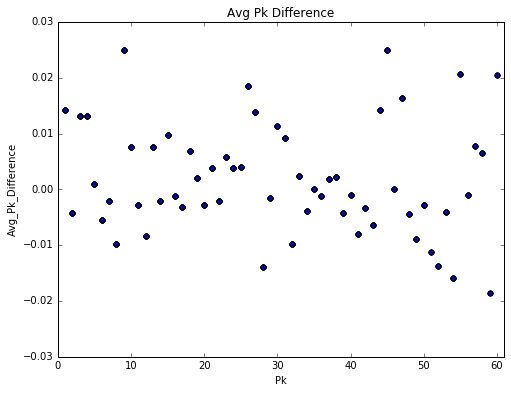

In [27]:
df['Avg_Pk_Difference'] = df.groupby('Pk')['Difference'].transform(lambda x: x.mean())

# There's a slight decline, but there's no strong need for an adjustment
df.plot(y='Avg_Pk_Difference', x='Pk', kind='scatter', \
          title='Avg Pk Difference', xlim=(0, 61), ylim=(-0.03, 0.03), figsize=(8, 6))

In [9]:
# Add up for each team since 1996
df_TM = df.groupby('Tm').mean()
df_TM = df_TM.sort('Difference', ascending=False)[['Difference']]
df_TM

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Difference
Tm,
SAS,0.022998
NOP,0.013434
IND,0.012889
HOU,0.010879
OKC,0.009767
BOS,0.009069
UTA,0.008588
GSW,0.007896
TOR,0.006518
